# Fit a transit of an oblate planet

Here we'll attempt to recover the parameters describing planetary oblateness from a realistic-ish simulated light curve. We'll focus on Kepler-167 e, a cold Jupiter-like planet that will be observed by JWST NIRSpec in Fall 2024.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import corner
import numpy as np
from scipy.optimize import minimize
from scipy import stats
from tqdm import tqdm
import warnings

from squishyplanet import OblateSystem

import astropy.units as u
import numpy as np
from scipy.interpolate import CubicSpline

from exotic_ld import StellarLimbDarkening
from exotic_ld.ld_laws import quadratic_ld_law, nonlinear_4param_ld_law

from tynt import Filter
from lightkurve import search_lightcurve, LightkurveWarning
from gadfly import (
    StellarOscillatorKernel,
    Hyperparameters,
    PowerSpectrum,
    GaussianProcess,
    ShotNoiseKernel,
)

from nautilus import Prior, Sampler

np.random.seed(13)

## Simulating the transit

### Limb darkening

Since limb darkening varies most during ingress/egress, the same time our expected oblateness signal will be strongest, it's important that we try to simulate it as accurately as possible in this injection/recovery exercise. There are many ways to approach fitting limb darkening, and we'll get to that later: here our goal is just simulation. 

We'll use the [ExoTiC-LD](https://exotic-ld.readthedocs.io/en/latest/index.html) ([Grand and Wakeford 2022](https://ui.adsabs.harvard.edu/abs/2022zndo...7437681G/abstract)) package's ability to convert stellar grids into limb darkening profiles. This is a great package and is capable of quickly fitting these profiles to some of the commonly used approximate limb darkening laws, like quadratic and four-parameter non-linear. However, we won't actually use this last fitting step: instead, we'll take advantage of `squishyplanet`'s ability to model high-order polynomials for limb darkening and directly fit the profiles ourselves.

We'll use the ATLAS library of model stellar atmosphere ([Kostogryz et al. 2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...666A..60K/abstract)) which `ExoTiC-LD` calls "mps1". `ExoTiC-LD` will download the relevant models automatically.

First, let's take a look at the spectrum and expected limb darkening profile for Kepler-167 e. ExoTiC-LD works in units of $\mu=\sqrt(1-r^2)$, where $r$ is the projected distance to the center of the star.

Input stellar parameters are M_H=0.02, Teff=4884, logg=4.579.
Loading stellar model from mps1 grid.
Using interpolation type = trilinear.
Trilinear interpolation within M_H=0.0-0.05, Teff=4800.0-4900.0, logg=4.5-4.6.
Stellar model loaded.
Loading instrument mode=JWST_NIRSpec_Prism with wavelength range 6000.0-53000.0 A.
Integrating I(mu) for wavelength limits of 6000-53000 A.
Integral done for I(mu).
Fitting limb-darkening law to 16 I(mu) data points where 0.1 <= mu <= 1, with the Levenberg-Marquardt algorithm.
Fit done, resulting coefficients are [0.21401188 0.23248826].

Loading instrument mode=JWST_NIRSpec_Prism with wavelength range 6000.0-53000.0 A.
Integrating I(mu) for wavelength limits of 6000-53000 A.
Integral done for I(mu).
Fitting limb-darkening law to 16 I(mu) data points where 0.1 <= mu <= 1, with the Levenberg-Marquardt algorithm.
Fit done, resulting coefficients are [ 0.5029766   0.12608973 -0.06546251 -0.00304448].


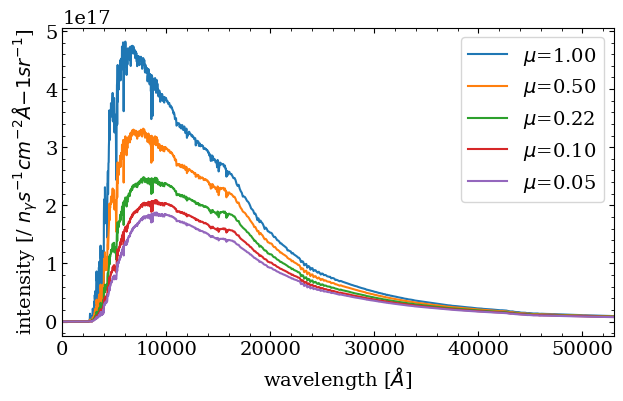

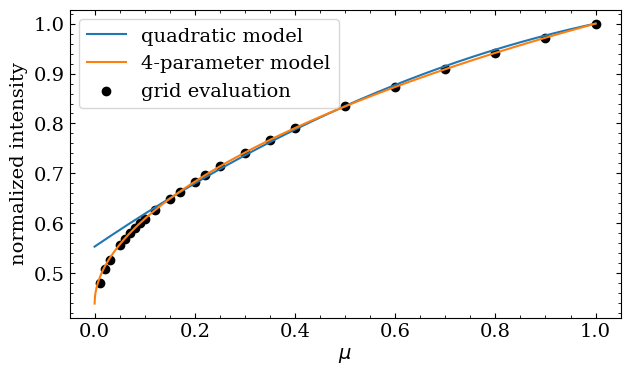

In [2]:
sld = StellarLimbDarkening(
    M_H=0.020,
    Teff=4884,
    logg=4.579,
    ld_model="mps1",
    ld_data_path="exotic_ld_data",
    interpolate_type="trilinear",
    custom_wavelengths=None,
    custom_mus=None,
    custom_stellar_model=None,
    ld_data_version="3.2.0",
    verbose=2,
)

quad_coeffs = sld.compute_quadratic_ld_coeffs(
    wavelength_range=[6_000, 53_000], # the bounds in angstroms of the Prism throughput
    mode="JWST_NIRSpec_Prism",
    custom_wavelengths=None,
    custom_throughput=None,
    mu_min=0.1,
)

print()
four_coeffs = sld.compute_4_parameter_non_linear_ld_coeffs(
    wavelength_range=[6_000, 53_000],
    mode="JWST_NIRSpec_Prism",
    custom_wavelengths=None,
    custom_throughput=None,
    mu_min=0.1,
)

# from the ExoTIC-LD tutorials:
fig, ax = plt.subplots()
for mu_idx in np.arange(0, sld.stellar_intensities.shape[1], 5):
    ax.plot(
        sld.stellar_wavelengths,
        sld.stellar_intensities[:, mu_idx],
        label=f"$\mu$={sld.mus[mu_idx]:.2f}",
    )
ax.legend()
ax.set(
    xlim=(0, 53_000),
    xlabel="wavelength [$\AA$]",
    ylabel="intensity [/ $n_{\gamma} s^{-1} cm^{-2} \AA{-1} sr^{-1}$]",
)


mu_grid = np.linspace(0.0, 1.0, 1_000) # for plotting the LD laws
quad_prediction = quadratic_ld_law(mu_grid, *quad_coeffs)
four_prediction = nonlinear_4param_ld_law(mu_grid, *four_coeffs)

fig, ax = plt.subplots()
ax.plot(mu_grid, quad_prediction, label="quadratic model")
ax.plot(mu_grid, four_prediction, label="4-parameter model")
ax.scatter(sld.mus, sld.I_mu, label="grid evaluation", color="k")
ax.set(xlabel="$\mu$", ylabel="normalized intensity")
ax.legend();

It's clear that the non-linear law does a much better job than the standard quadratic approximation: unfortunately, `squishyplanet` can't model limb darkening in this form. What it *can* do is model limb darkening as a high-order polynomial, which should be able to capture the non-linear behavior. Since we have 24 points in the profile, we could fit up to 23rd-order, but we'll limit ourselves to something lower to avoid overfitting issues.

We can perform the fit with `squishyplanet`'s `OblateSystem.fit_limb_darkening_profile`
method. We can then visualize the fit with `squishyplanet`'s `OblateSystem.limb_darkening_profile` method.

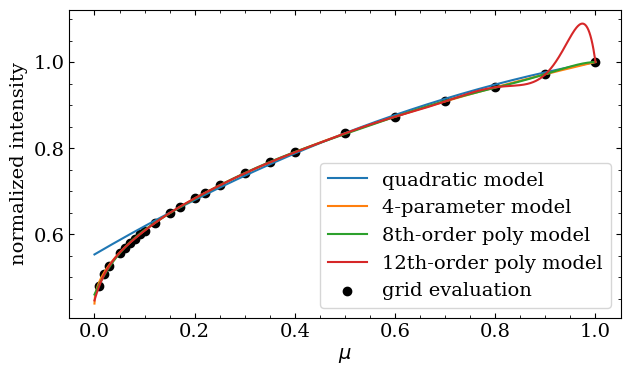

In [3]:
# compute the best-fit polynomial model
u_coeffs = OblateSystem.fit_limb_darkening_profile(
    intensities=sld.I_mu, mus=sld.mus, order=8
)
# evaluate that model on the mu grid
poly_model = OblateSystem.limb_darkening_profile(ld_u_coeffs=u_coeffs, mu=mu_grid)
# ExoTIC-LD scales the intensity profile by the intensity at mu=0,
# while squishyplanet scales it so the integrated intensity is 1.0. rescale
# ours to match theirs:
norm = OblateSystem.limb_darkening_profile(ld_u_coeffs=u_coeffs, r=0)
poly_model /= norm

# same game, higher order polynomial
u_coeffs2 = OblateSystem.fit_limb_darkening_profile(
    intensities=sld.I_mu, mus=sld.mus, order=12
)
poly_model2 = OblateSystem.limb_darkening_profile(ld_u_coeffs=u_coeffs2, mu=mu_grid)
norm2 = OblateSystem.limb_darkening_profile(ld_u_coeffs=u_coeffs2, r=0)
poly_model2 /= norm2

fig, ax = plt.subplots()
ax.plot(mu_grid, quad_prediction, label="quadratic model")
ax.plot(mu_grid, four_prediction, label="4-parameter model")
ax.plot(mu_grid, poly_model, label="8th-order poly model")
ax.plot(mu_grid, poly_model2, label="12th-order poly model")
ax.scatter(sld.mus, sld.I_mu, label="grid evaluation", color="k")
ax.set(xlabel="$\mu$", ylabel="normalized intensity")
ax.legend();

The 8th-order is a much better than the quadratic approximation! But, as you can see with the 12th order fit, polynomials are really sensitive to overfitting and doing strange things between the evaluated grid points. To avoid this, let's fit a cubic spline to the profile, evaluate it on a finer grid, then fit a polynomial to that instead:

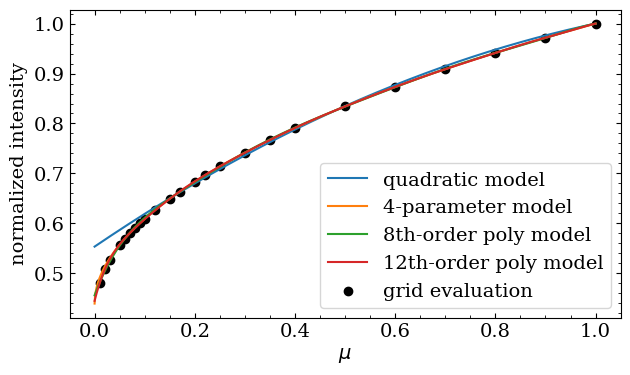

In [4]:
# interpolate between the grid points
order = np.argsort(sld.mus)
spline_approx = CubicSpline(x=sld.mus[order], y=sld.I_mu[order])
interpolated_vals = spline_approx(mu_grid)

# exact same as above, but now fitting to the interpolated values
u_coeffs = OblateSystem.fit_limb_darkening_profile(
    intensities=interpolated_vals, mus=mu_grid, order=8
)
poly_model = OblateSystem.limb_darkening_profile(ld_u_coeffs=u_coeffs, mu=mu_grid)
norm = OblateSystem.limb_darkening_profile(ld_u_coeffs=u_coeffs, r=0)
poly_model /= norm


u_coeffs2 = OblateSystem.fit_limb_darkening_profile(
    intensities=interpolated_vals, mus=mu_grid, order=12
)
poly_model2 = OblateSystem.limb_darkening_profile(ld_u_coeffs=u_coeffs2, mu=mu_grid)
norm2 = OblateSystem.limb_darkening_profile(ld_u_coeffs=u_coeffs2, r=0)
poly_model2 /= norm2

fig, ax = plt.subplots()
ax.plot(mu_grid, quad_prediction, label="quadratic model")
ax.plot(mu_grid, four_prediction, label="4-parameter model")
ax.plot(mu_grid, poly_model, label="8th-order poly model")
ax.plot(mu_grid, poly_model2, label="12th-order poly model")
ax.scatter(sld.mus, sld.I_mu, label="grid evaluation", color="k")
ax.set(xlabel="$\mu$", ylabel="normalized intensity")
ax.legend();

Looking much better!

As an aside, although it looks as thought the quadratic is a pretty bad fit, it's worth remembering that $\mu$ is defined as $\sqrt(1-r^2)$, where $r$ is the projected distance to the center of the star. A planet's motion will be more linear in $r$ than $\mu$ (exactly linear if it has a non-zero impact parameter), so let's see how the fits look when reparameterized:

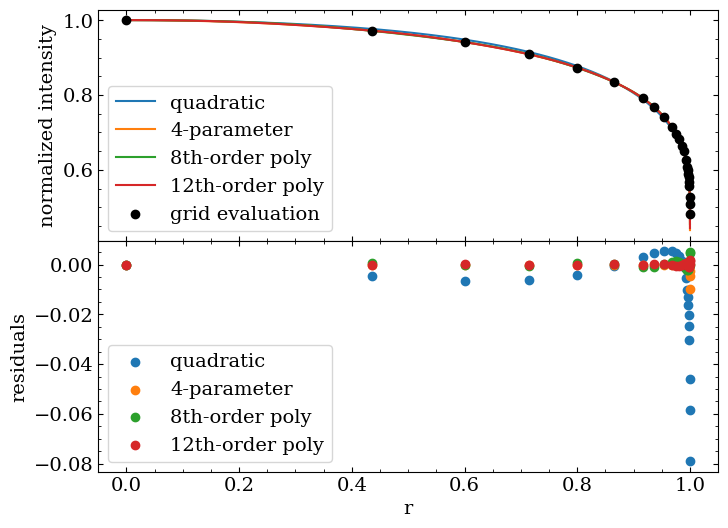

In [5]:
# convert mu->r
r_grid = np.sqrt(1 - mu_grid**2)

# evaluate our models on the r grid
poly_model1 = OblateSystem.limb_darkening_profile(ld_u_coeffs=u_coeffs, r=r_grid) / norm
poly_model2 = (
    OblateSystem.limb_darkening_profile(ld_u_coeffs=u_coeffs2, r=r_grid) / norm2
)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))
ax[0].plot(r_grid, quad_prediction, label="quadratic")
ax[0].plot(r_grid, four_prediction, label="4-parameter")
ax[0].plot(r_grid, poly_model, label="8th-order poly")
ax[0].plot(r_grid, poly_model2, label="12th-order poly")
ax[0].scatter(
    np.sqrt(1 - sld.mus**2), sld.I_mu, label="grid evaluation", color="k", zorder=10
)
ax[0].set(ylabel="normalized intensity")
ax[0].legend()

rs = np.sqrt(1 - sld.mus**2)
ax[1].scatter(rs, sld.I_mu - quadratic_ld_law(sld.mus, *quad_coeffs), label="quadratic")
ax[1].scatter(
    rs, sld.I_mu - nonlinear_4param_ld_law(sld.mus, *four_coeffs), label="4-parameter"
)
ax[1].scatter(
    rs,
    sld.I_mu - OblateSystem.limb_darkening_profile(ld_u_coeffs=u_coeffs, r=rs) / norm,
    label="8th-order poly",
)
ax[1].scatter(
    rs,
    sld.I_mu - OblateSystem.limb_darkening_profile(ld_u_coeffs=u_coeffs2, r=rs) / norm2,
    label="12th-order poly",
)
ax[1].set(xlabel="r", ylabel="residuals")
ax[1].legend()
plt.subplots_adjust(hspace=0);

So, quadratic really only breaks down at the very edge of the star and mostly agrees with the others for $\sim98$% of the radial positions, which for most use cases is fine. Still, that can have an impact when you're looking for subtle effects that manifest at those exact moments. We can quantify the effect of slightly mis-specified limb darkening on a transit by creating light curves with the different order polynomial approximations:

100%|██████████| 12/12 [04:18<00:00, 21.51s/it]


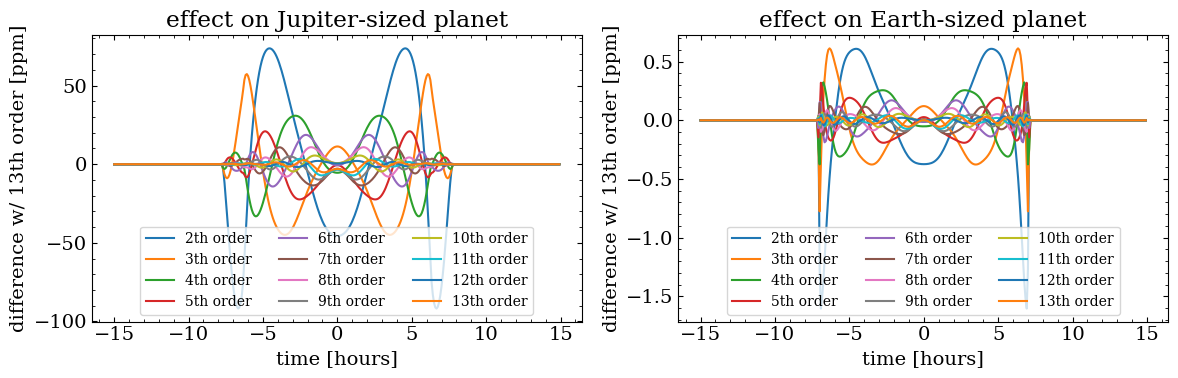

In [6]:
t_exp = 5 * u.min
times = jnp.arange(-15, 15, t_exp.to(u.hour).value) * u.hour.to(u.day)


# comparison curve with high-order polynomial
u_coeffs = OblateSystem.fit_limb_darkening_profile(
    intensities=interpolated_vals, mus=mu_grid, order=14
)
state = {
    "t_peri": -250.0,
    "times": times,
    "a": 540.0,
    "period": 1_000.0,
    "r": (1 * u.R_jup).to(u.R_sun).value,
    "ld_u_coeffs": u_coeffs,
    "tidally_locked": False,
}
limb_darkening_demo_system = OblateSystem(**state)
lc_base = limb_darkening_demo_system.lightcurve()
lc_base2 = limb_darkening_demo_system.lightcurve(
    {"r": (1 * u.R_earth).to(u.R_sun).value}
)

# loop through different orders of the polynomial
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
for order in tqdm(np.arange(2, 14, 1)):
    u_coeffs = OblateSystem.fit_limb_darkening_profile(
        intensities=interpolated_vals, mus=mu_grid, order=order
    )

    # need to create a new system each time, since the order of the limb darkening
    # law sets the Green's basis transformation matrix which is only computed on
    # initialization
    state = {
        "t_peri": -250.0,
        "times": times,
        "a": 540.0,
        "period": 1_000.0,
        "r": (1 * u.R_jup).to(u.R_sun).value,
        "ld_u_coeffs": u_coeffs,
        "tidally_locked": False,
    }
    limb_darkening_demo_system = OblateSystem(**state)
    lc = limb_darkening_demo_system.lightcurve()
    ax[0].plot(times * u.day.to(u.hour), (lc_base - lc) * 1e6, label=f"{order}th order")

    lc2 = limb_darkening_demo_system.lightcurve(
        {"r": (1 * u.R_earth).to(u.R_sun).value}
    )
    ax[1].plot(
        times * u.day.to(u.hour), (lc_base2 - lc2) * 1e6, label=f"{order}th order"
    )

ax[0].set(
    xlabel="time [hours]",
    ylabel="difference w/ 13th order [ppm]",
    title="effect on Jupiter-sized planet",
)
ax[0].legend(loc="lower center", ncol=3, prop={"size": 10})
ax[1].set(
    xlabel="time [hours]",
    ylabel="difference w/ 13th order [ppm]",
    title="effect on Earth-sized planet",
)
ax[1].legend(loc="lower center", ncol=3, prop={"size": 10})
plt.tight_layout();

Unsurprisingly, the larger the planet, the more subtle changes to the limb darkening law matters. A Jupiter-sized planet covers more radial positions than an Earth-sized planet, so changes between laws start to stand out more. Keep in mind, the 14th order polynomial isn't "correct" either, it's just our comparison curve. It's a bummer that most oblate planets will be closer to Jupiter-sized than Earth-sized, but there's not much we can do about that. We'll just to use a fitting procedure that appropriately handles trade-offs between limb darkening and oblateness.

Moving ahead, we'll use the 14th-order coefficients to simulate the transit. With those set, let's go ahead and simulate the "ideal" transit. For this, we'll use parameters reported in [Chachan et al. 2020](https://ui.adsabs.harvard.edu/abs/2022ApJ...926...62C/abstract), then assume the planet is as oblate as and has the same obliquity of Saturn, and a randomly-chosen precession angle of 60 degrees.

The JWST observations will have a cadence of ~1.6s, a white light precision of ~540 ppm, and a baseline of ~60 hours. Since that's an enormous amount of data, we'll only simulate 40 hours and bin the data to a 5-minute cadence, but will be sure to add the finite exposure time correction to model the resulting transit blurring.

In [7]:
t_exp = 5 * u.min
times = jnp.arange(-20, 20, t_exp.to(u.hour).value) * u.hour.to(u.day)

# generate the stellar intensities
sld = StellarLimbDarkening(
    M_H=0.020,
    Teff=4884,
    logg=4.579,
    ld_model="mps1",
    ld_data_path="exotic_ld_data",
    interpolate_type="trilinear",
    custom_wavelengths=None,
    custom_mus=None,
    custom_stellar_model=None,
    ld_data_version="3.2.0",
    verbose=0,
)
sld._integrate_I_mu(
    wavelength_range=[6_000, 53_000],
    mode="JWST_NIRSpec_Prism",
    custom_wavelengths=None,
    custom_throughput=None,
)

# interpolate the stellar intensities
mu_grid = np.linspace(0.0, 1.0, 1_000)
order = np.argsort(sld.mus)
f = CubicSpline(x=sld.mus[order], y=sld.I_mu[order])
interpolated_vals = f(mu_grid)

# fit the limb darkening profile
u_coeffs = OblateSystem.fit_limb_darkening_profile(
    intensities=interpolated_vals, mus=mu_grid, order=14
)

# create the planet
injected_state = {
    "t_peri": -1071.23205 / 4,  # going to make it circular with mid-transit at t=0
    "times": times,
    "exposure_time": t_exp.to(u.day).value,
    "oversample": 3,  # 3x more samples under-the-hood, then binned back down
    "oversample_correction_order": 2,
    "a": ((1.883 * u.au) / (0.749 * u.R_sun)).to(u.dimensionless_unscaled),
    "period": 1071.23205,
    "r": ((0.9064 * u.R_jup) / (0.749 * u.R_sun)).to(u.dimensionless_unscaled),
    "i": 89.9720 * jnp.pi / 180,
    "ld_u_coeffs": u_coeffs,
    "f1": 0.1,  # ~Saturn oblateness
    "obliq": 26.7 * jnp.pi / 180,  # Saturn obliquity
    "prec": 60.0 * jnp.pi / 180,  # randomly chosen
    "tidally_locked": False,
}

injected_planet = OblateSystem(**injected_state)

# create a spherical planet with the same projected area and orbital parameters for comparison
spherical_planet_state = injected_state.copy()
spherical_planet_state["r"] = injected_planet.state["projected_effective_r"]
spherical_planet_state["f1"] = 0.0
spherical_planet = OblateSystem(**spherical_planet_state)

# generate the lightcurves
injected_transit = injected_planet.lightcurve()
spherical_transit = spherical_planet.lightcurve()

Let's inspect what we just created. We can plot the projected outline of the planet using `injected_planet.illustrate`, then plot the light curve and its comparsion to the one created by the spherical planet:

Projected flattening: 0.0841214397044389


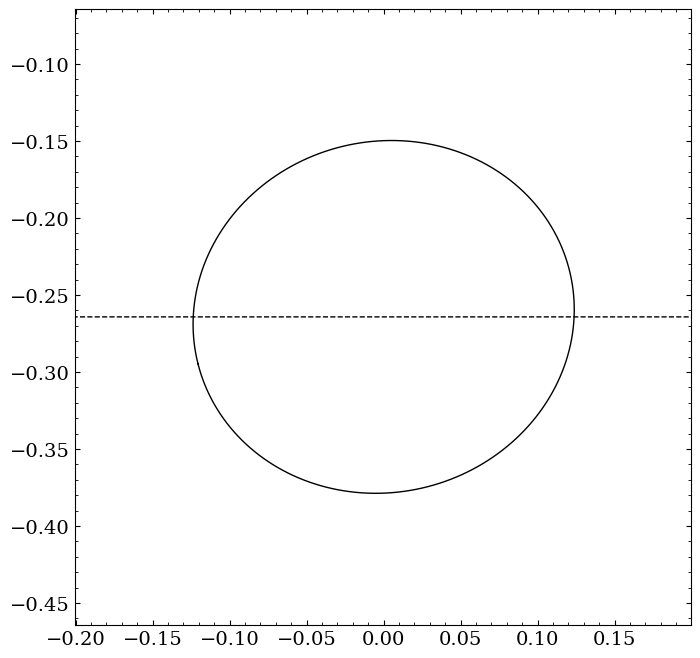

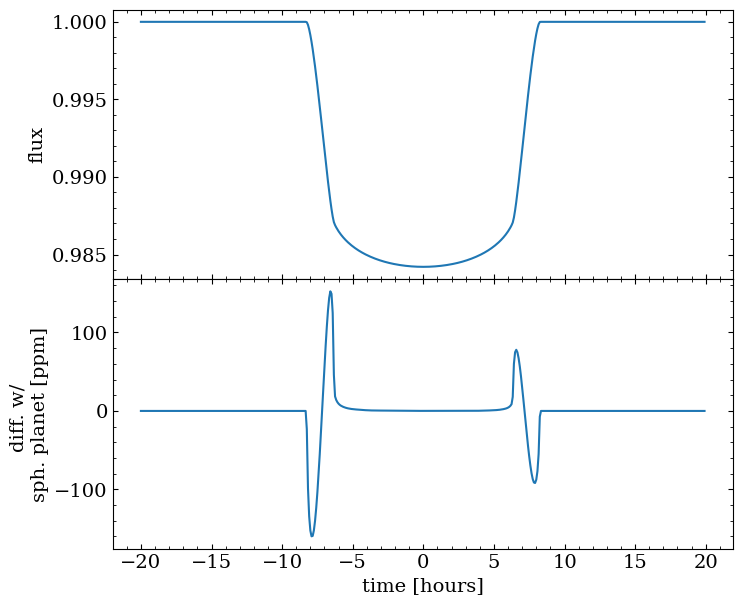

In [8]:
print(f"Projected flattening: {injected_planet.state['projected_f']}")

injected_planet.illustrate(star_fill=False) # suppress the star fill for clarity

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 7))
ax[0].plot(times * u.day.to(u.hour), injected_transit)
ax[0].set(ylabel="flux")
ax[1].plot(times * u.day.to(u.hour), (injected_transit - spherical_transit) * 1e6)
ax[1].set(ylabel="diff. w/ \nsph. planet [ppm]", xlabel="time [hours]")
plt.subplots_adjust(hspace=0);

So, we're looking for an effect that's ~100 ppm, and asymmetric.

The projected flattening value, f, is less than the true injected f value: that's because we've given the planet some obliquity, which leaves us with a more circular projected ellipse when we only flatten along the $z$ axis with $f_1$ (if the obliquity was a full 90 degrees, we'd see a perfect circle). See [Berardo and de Wit 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...935..178B/abstract) for more details.

Lastly, let's double check that our oversampling correction is sufficient to account for smearing caused by the finite exposure time binning:

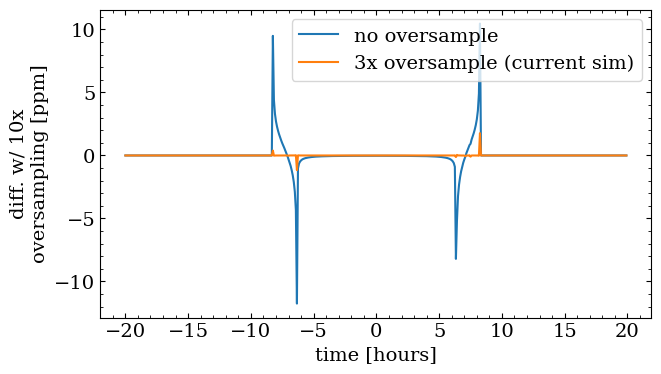

In [9]:
no_oversample_planet_state = injected_state.copy()
no_oversample_planet_state["oversample"] = 1
no_oversample_planet = OblateSystem(**no_oversample_planet_state)
no_oversample_transit = no_oversample_planet.lightcurve()

supersampled_planet_state = injected_state.copy()
supersampled_planet_state["oversample"] = 10
supersampled_planet = OblateSystem(**supersampled_planet_state)
supersampled_transit = supersampled_planet.lightcurve()

fig, ax = plt.subplots()
ax.plot(
    times * u.day.to(u.hour),
    (no_oversample_transit - supersampled_transit) * 1e6,
    label="no oversample",
)
ax.plot(
    times * u.day.to(u.hour),
    (injected_transit - supersampled_transit) * 1e6,
    label="3x oversample (current sim)",
)
ax.legend()
ax.set(ylabel="diff. w/ 10x\noversampling [ppm]", xlabel="time [hours]");

We're safely in the <2ppm regime here, so we'll stick with the 3x oversample to avoid unnecessary computation.

### Noise addition

Now we need to add noise to this injected model. This will include white noise from photon counting statistics and from instrument readout (which here we'll also assume is white). The [JWST Exposure Time Calculator](https://jwst.etc.stsci.edu/) suggests that combined, this will be about ~540 ppm for each 1.6s integration, taken with 6 groups per up-the-ramp sample. We'll scale that to our 5-minute cadence, and add it to the light curve.

In addition, we should check if the star itself will contribute any meaningful correlated noise to the light curve. For that we'll use the
[gadfly](https://gadfly-astro.readthedocs.io/en/latest/) and [lightkurve](http://docs.lightkurve.org/) packages to inspect previous Kepler observations of the host star. The following plot will closely resemble those created in the gadfly documentation, so we recommend checking that out for more details.

We'll inspect the long and short cadence data collected by Kepler, then use both the [Lomb-Scargle periodogram](https://docs.astropy.org/en/stable/timeseries/lombscargle.html) and the [fast Fourier transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html) to look for signs of non-white noise. To make sure we aren't being fooled by a detrending choice, we'll detrend the raw data using 0th-3rd order polynomials, then compare the periodograms.

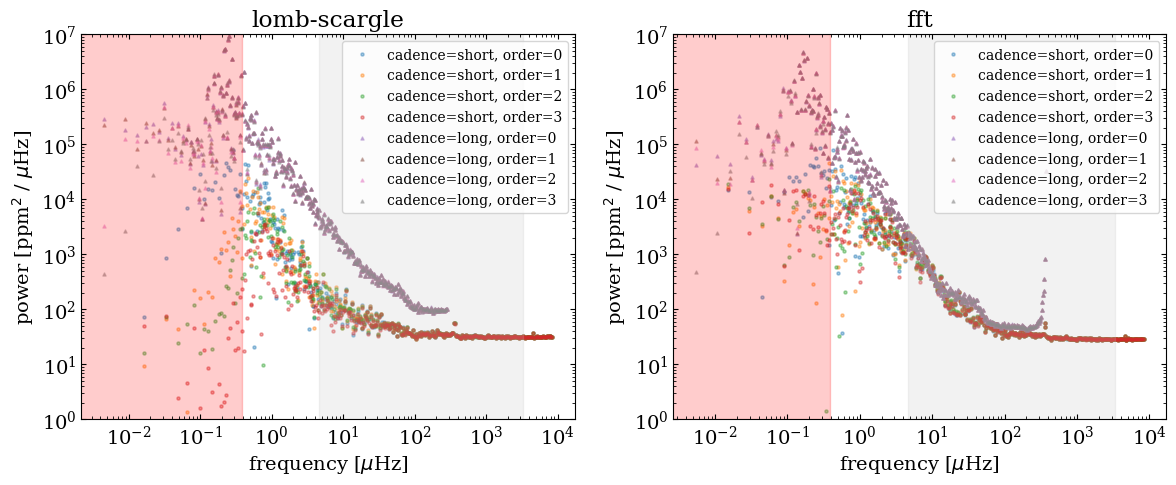

In [10]:
# define grid of parameters to vary
cadences = ["short", "long"]
methods = ["lomb-scargle", "fft"]
poly_orders = [0, 1, 2, 3]

# setup the plot
fig, ax = plt.subplots(figsize=(14, 5), ncols=2)
ax[0].set(
    xscale="log",
    yscale="log",
    ylim=(1, 1e7),
    xlabel="frequency [$\mu$Hz]",
    ylabel="power [ppm$^2$ / $\mu$Hz]",
    title="lomb-scargle",
)
ax[1].set(
    xscale="log",
    yscale="log",
    ylim=(1, 1e7),
    xlabel="frequency [$\mu$Hz]",
    ylabel="power [ppm$^2$ / $\mu$Hz]",
    title="fft",
)

# loop through all of the combinations of cadence, method, and polynomial order
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for cadence in cadences:
        for method in methods:
            for poly_order in poly_orders:
                light_curve = search_lightcurve(
                    "Kepler-167", mission="Kepler", cadence=cadence
                ).download_all()

                if cadence == "short":
                    b = 100
                    m = "o"
                else:
                    b = 100
                    m = "^"

                ps = PowerSpectrum.from_light_curve(
                    light_curve,
                    include_zero_freq=False,
                    name=None,
                    detrend=True,
                    detrend_poly_order=poly_order,
                    save_detrended_lc=False,
                    method=method,
                ).bin(500)

                if method == "lomb-scargle":
                    a = ax[0]
                else:
                    a = ax[1]

                a.scatter(
                    ps.frequency.value,
                    ps.power.value,
                    marker=m,
                    alpha=0.4,
                    zorder=-10,
                    s=5,
                    label=f"cadence={cadence}, order={poly_order}",
                )
ax[0].legend(prop={"size" : 10})
ax[1].legend(prop={"size" : 10})

kepler_cutoff_frequency = (1 / (30 * u.day)).to(u.uHz).value
obs_duration = 60 * u.hour
t_exp = 5 * u.min
ax[0].axvspan(0, kepler_cutoff_frequency, color="red", alpha=0.2)
ax[0].axvspan(
    (1 / obs_duration).to(u.uHz).value,
    ((1 / t_exp).to(u.uHz)).value,
    color="silver",
    alpha=0.2,
)
ax[1].axvspan(0, kepler_cutoff_frequency, color="red", alpha=0.2)
ax[1].axvspan(
    (1 / obs_duration).to(u.uHz).value,
    ((1 / t_exp).to(u.uHz)).value,
    color="silver",
    alpha=0.2,
);

Following the gadly documentation, we've highlighted in red the low-frequency regions that are suspect due to Kepler's detrending choices. We've also highlight frequencies relevant to our observations in silver, spanning the observation duration down to the exposure time. We can see that the noise is relatively white at the frequencies we care about: we get a slight 1/f trend towards low frequencies, but no major peaks or signs of periodicity. Let's check what gadfly suggests as a model for the noise:

/Users/cassese/miniconda3/envs/oblate/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:102: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


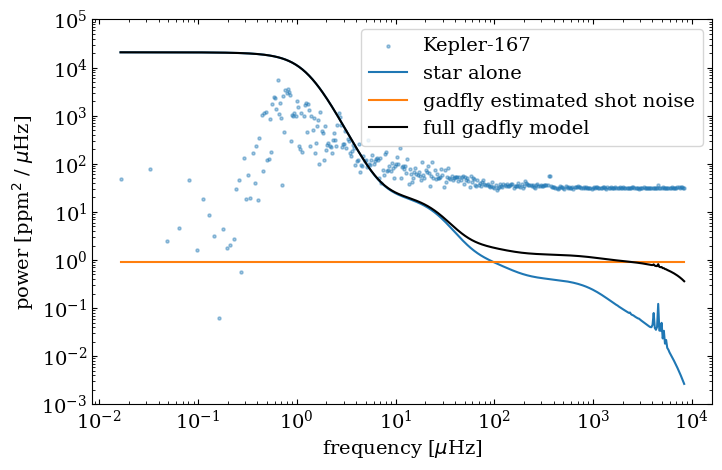

In [11]:
hp = Hyperparameters.for_star(
    mass=0.777 * u.M_sun, # values again from Chachan+ 2020
    radius=0.749 * u.R_sun,
    temperature=4884 * u.K,
    luminosity=10 ** (-0.539) * u.L_sun,
    name="Kepler-167",
    bandpass="Kepler/Kepler.K",
)

light_curve = search_lightcurve(
    "Kepler-167",
    mission="Kepler",
    cadence="short",
).download_all()

# isolate the power spectrum from the star alone
star_alone = StellarOscillatorKernel(hp, texp=1 * u.min, name="test")

# create a kernel that estimates the shot noise
estimated_shot_noise = ShotNoiseKernel.from_kepler_light_curve(light_curve)

# add them into a final combined kernel
combined = star_alone + estimated_shot_noise

ps = PowerSpectrum.from_light_curve(
    light_curve,
    include_zero_freq=False,
    name=None,
    detrend=True,
    detrend_poly_order=poly_order,
    save_detrended_lc=False,
    method="lomb-scargle",
).bin(500)
freq = ps.frequency

fig, ax = plt.subplots(figsize=(8, 5))
ax.set(
    xscale="log",
    yscale="log",
    ylim=(1e-3, 1e5),
    xlabel="frequency [$\mu$Hz]",
    ylabel="power [ppm$^2$ / $\mu$Hz]",
)
ax.scatter(
    ps.frequency.value,
    ps.power.value,
    marker="o",
    alpha=0.4,
    zorder=-10,
    s=5,
    label=f"Kepler-167",
)
ax.plot(
    ps.frequency.value,
    star_alone.get_psd(2 * np.pi * freq.to(u.uHz).value),
    label="star alone",
)
ax.plot(
    ps.frequency.value,
    estimated_shot_noise.get_psd(2 * np.pi * freq.to(u.uHz).value),
    label="gadfly estimated shot noise",
)
ax.plot(
    ps.frequency.value,
    combined.get_psd(2 * np.pi * freq.to(u.uHz).value),
    label="full gadfly model",
    color="k",
)
ax.legend();

This isn't such a good fit, which is unsurprising since Kepler-167 is a quiet K dwarf, very unlike giant stars with strong p-modes that this model was designed for. The fact that the PSD is pretty flat at the frequencies we care about (even in the Kepler bandpass, which is bluer than Prism's) suggests that we can just use a white noise model for the star. We'll add that to the light curve, then plot the final simulation:

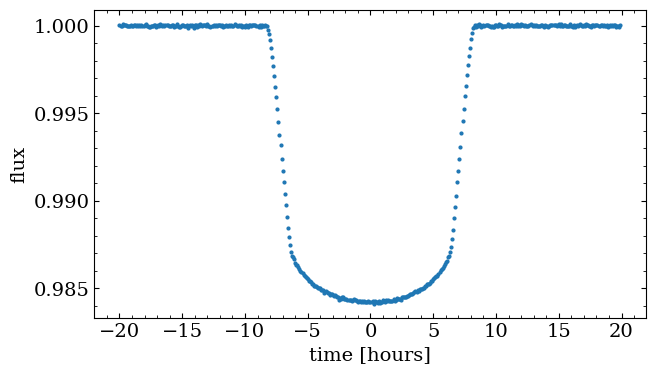

In [12]:
# scale the shot noise/integration to our longer binned light curve
shot_noise_amplitude = (540 * 1e-6) / jnp.sqrt(
    ((t_exp) / (1.6 * u.s)).to(u.dimensionless_unscaled)
)
shot_noise = (
    jax.random.normal(jax.random.PRNGKey(0), times.shape) * shot_noise_amplitude
)

noised_data = injected_transit + shot_noise

fig, ax = plt.subplots()
ax.plot(times * u.day.to(u.hour), noised_data, marker="o", markersize=2, ls="none")
ax.set(ylabel="flux", xlabel="time [hours]");

And that's our simulated data!

## Fitting the transit

### Initial best-fit solution

Now that we have some simulated data, let's use `squishyplanet` to fit it. We'll start by finding the maximum likelihood solution for the transit parameters.

initial loglike: -114320.86235514122


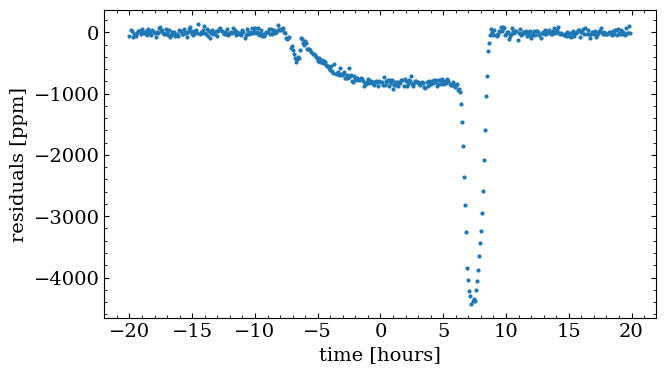

In [13]:
# slightly perturbed parameters compared to the injected_state
init_state = {
    "times": times,
    "data": noised_data, # first time we've used this: by saving data, we can use the loglike method
    "uncertainties": jnp.ones_like(noised_data) * shot_noise_amplitude, # also need these
    "exposure_time": t_exp.to(u.day).value,
    "oversample": 3,
    "oversample_correction_order": 2,
    "period": 1071.23205,
    "t_peri": -1071.23205 / 4 + 0.01,
    "tidally_locked": False,
    "parameterize_with_projected_ellipse": True,
    "a": 540.0,
    "i": 90 * jnp.pi / 180,
    "ld_u_coeffs": jnp.array([0.3, 0.2]),
    "projected_effective_r": 0.12,
    "projected_f": 0.0,
    "projected_theta": 0.0,
    "log_jitter": -jnp.inf,
}

planet = OblateSystem(**init_state)  # the system we'll use for all our fits!

# evaluate this likelihood
print(f"initial loglike: {planet.loglike()}")

init_lc = planet.lightcurve()
fig, ax = plt.subplots()
ax.errorbar(
    times * u.day.to(u.hour),
    (init_lc - noised_data) * 1e6,
    yerr=shot_noise_amplitude,
    marker="o",
    markersize=2,
    ls="none",
)
ax.set(ylabel="residuals [ppm]", xlabel="time [hours]");

That's obviously not a great fit (the errorbars are there, just smaller than the points), but it's just our starting point. Though the above cell takes a few seconds to run, thanks to the jit-compilation, each subsequent likelihood evaluation will be faster than the initial one:

In [14]:
%timeit planet.loglike().block_until_ready()

17.3 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


To get an initial estimate of the best fit, we can use scipy's minimize routines. Though we could leave the limb darkening fixed to the values we calculated above, to demonstrate how you might fit for the limb darkening parameters, we'll use the [Kipping 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.435.2152K/abstract) parameterization and fit for $q_1$ and $q_2$, which have uniform priors between [0,1] and can be directly converted into the $u_1$ and $u_2$ coefficients that define a quadratic limb darkening law. We'll also put wide bounds on the other parameters that roughly match the priors we'll use later, just to keep anything from running away.

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -4174.3624548976595
        x: [-2.678e+02  5.421e+02  2.576e-01  1.697e-01  2.959e-01
             1.191e-01  9.230e-02  2.543e-01 -1.573e+01]
      nit: 109
      jac: [ 1.901e+00 -1.692e-02 -3.452e-01 -2.387e-01 -2.829e-02
            -1.797e+00  1.601e-02 -4.820e-03 -2.728e-04]
     nfev: 1270
     njev: 127
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>

Optimized parameters:
a: 542.0738178296012
i: 1.5703211496625755
ld_u_coeffs: [0.24382571 0.16817937]
log_jitter: -15.726116359073147
projected_effective_r: 0.11910624859934747
projected_f: 0.09230017510333419
projected_theta: 0.2543057985470075
t_peri: -267.80796569879


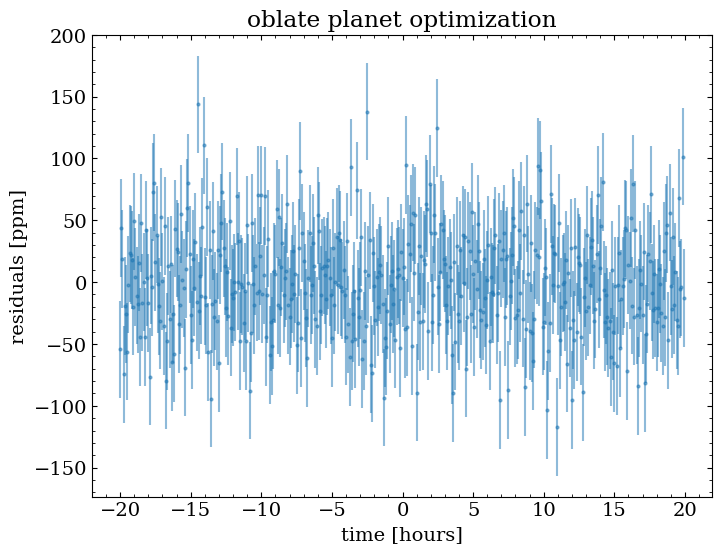

In [15]:
np.random.seed(10)

# scipy works in arrays, squishyplanet in dictionaries
# this function translates between the two
@jax.jit
def translate_to_dict(x): 
    # we're using t_peri here instead of t0, but the posterior shapes will look the same
    # for circular orbits
    t_peri = x[0] 
    a = x[1]
    impact_param = x[2]
    i = jnp.arccos(impact_param / a)
    q1 = x[3]  # using the Kipping 2013 uninformative quadratic limb darkening setup
    q2 = x[4]
    u1 = 2 * jnp.sqrt(q1) * q2 # convert to u1, u2
    u2 = jnp.sqrt(q1) * (1 - 2 * q2)
    projected_effective_r = x[5]
    projected_f = x[6]
    projected_theta = x[7]
    log_jitter = x[8]

    param_dict = {
        "t_peri": t_peri,
        "a": a,
        "i": i,
        "ld_u_coeffs": jnp.array([u1, u2]),
        "projected_effective_r": projected_effective_r,
        "projected_f": projected_f,
        "projected_theta": projected_theta,
        "log_jitter": log_jitter,
    }
    return param_dict

# our objective
def minimizer_fn(x):
    param_dict = translate_to_dict(x)
    return -planet.loglike(param_dict)

# starting point
init_guess = jnp.array(
    [
        init_state["t_peri"],
        init_state["a"],
        init_state["a"] * jnp.cos(init_state["i"]) + 0.05,
        init_state["ld_u_coeffs"][0] ** 2,
        init_state["ld_u_coeffs"][0] * init_state["ld_u_coeffs"][1] / 2,
        init_state["projected_effective_r"],
        init_state["projected_f"],
        init_state["projected_theta"],
        init_state["log_jitter"],
    ]
)

# run the minimizer with wide bounds on each parameter
res1 = minimize(
    minimizer_fn,
    init_guess,
    bounds=[
        (-1071.23205 / 4 - 0.15, -1071.23205 / 4 + 0.15), # t_peri, +/- 0.15 days
        (530.0, 550.0), # a, 530-550 days
        (0.0, 1.0), # impact parameter (b), 0-1 (so excludes extreme grazing but guarantees a transit)
        (0.0, 1.0), # q1, 0-1
        (0.0, 1.0), # q2, 0-1
        (0.10, 0.13), # projected_effective_r, 0.10-0.13
        (0.0, 0.3), # projected_f, 0-0.3 (0.3 is a pretty extreme oblateness)
        (0.0, jnp.pi), # projected_theta, 0-180 degrees
        (jnp.log(1e-7), jnp.log(1e-4)), # log_jitter, meaning an jitter of 1e-7 to 1e-4
    ],
)

oblate_resids = planet.lightcurve(translate_to_dict(res1.x)) - noised_data

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    times * u.day.to(u.hour),
    oblate_resids * 1e6,
    yerr=shot_noise_amplitude * 1e6,
    marker="o",
    markersize=2,
    ls="none",
    alpha=0.5,
)

ax.set(
    ylabel="residuals [ppm]", xlabel="time [hours]", title="oblate planet optimization"
);

print(res1)
print("\nOptimized parameters:")
for key in translate_to_dict(res1.x):
    print(f"{key}: {translate_to_dict(res1.x)[key]}")

That's much better!

To get a sense of how important oblateness is in the fit, let's do the same optimization while fixing the oblateness to zero:

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -4161.846690450233
        x: [-2.678e+02  5.325e+02  3.136e-01  1.719e-01  2.906e-01
             1.194e-01 -1.561e+01]
      nit: 83
      jac: [-2.370e+00  4.638e-03  7.442e-01  1.021e+00  2.305e-01
             4.611e+01 -8.185e-04]
     nfev: 776
     njev: 97
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

Optimized parameters:
a: 532.5438981765973
i: 1.5702074377754847
ld_u_coeffs: [0.24096276 0.1736903 ]
log_jitter: -15.610399894284074
projected_effective_r: 0.11936536965404794
t_peri: -267.807968103391


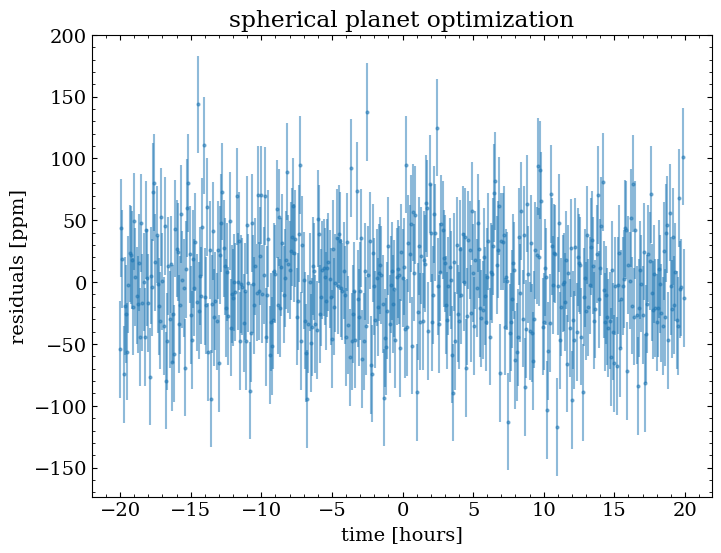

In [16]:
# exact same as above, but with the f and theta terms left out
np.random.seed(10)


@jax.jit
def translate_to_dict(x):
    t_peri = x[0]
    a = x[1]
    impact_param = x[2]
    i = jnp.arccos(impact_param / a)
    q1 = x[3]  # using the Kipping 2013 uninformative quadratic limb darkening setup
    q2 = x[4]
    u1 = 2 * jnp.sqrt(q1) * q2
    u2 = jnp.sqrt(q1) * (1 - 2 * q2)
    projected_effective_r = x[5]
    # projected_f = x[6]
    # projected_theta = x[7]
    log_jitter = x[6]

    param_dict = {
        "t_peri": t_peri,
        "a": a,
        "i": i,
        "ld_u_coeffs": jnp.array([u1, u2]),
        "projected_effective_r": projected_effective_r,
        # "projected_f": projected_f,
        # "projected_theta": projected_theta,
        "log_jitter": log_jitter,
    }
    return param_dict


def minimizer_fn(x):
    param_dict = translate_to_dict(x)
    return -planet.loglike(param_dict)


init_guess = jnp.array(
    [
        init_state["t_peri"],
        init_state["a"],
        init_state["a"] * jnp.cos(init_state["i"]) + 0.05,
        init_state["ld_u_coeffs"][0] ** 2,
        init_state["ld_u_coeffs"][0] * init_state["ld_u_coeffs"][1] / 2,
        init_state["projected_effective_r"],
        # init_state["projected_f"],
        # init_state["projected_theta"],
        init_state["log_jitter"],
    ]
)

res2 = minimize(
    minimizer_fn,
    init_guess,
    bounds=[
        (-1071.23205 / 4 - 0.15, -1071.23205 / 4 + 0.15),
        (530.0, 550.0),
        (0.0, 1.0),
        (0.0, 1.0),
        (0.0, 1.0),
        (0.10, 0.13),
        # (0.0, 0.3),
        # (0.0, jnp.pi),
        (jnp.log(1e-7), jnp.log(1e-4)),
    ],
)

sphere_resids = planet.lightcurve(translate_to_dict(res2.x)) - noised_data

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    times * u.day.to(u.hour),
    sphere_resids * 1e6,
    yerr=shot_noise_amplitude * 1e6,
    marker="o",
    markersize=2,
    ls="none",
    alpha=0.5,
)

ax.set(
    ylabel="residuals [ppm]",
    xlabel="time [hours]",
    title="spherical planet optimization",
);

print(res2)
print("\nOptimized parameters:")
for key in translate_to_dict(res2.x):
    print(f"{key}: {translate_to_dict(res2.x)[key]}")

Even though we're forcing it to fit a mis-specified model, by eye at least the fit is still pretty good. To more rigorously compare the two models, let's use two statistical tests: the [Bayesian Information Criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) and the [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion). These tests penalize models with more free parameters, so we can use them to determine if the likelihood improvement we get using the oblate model is justified by its extra terms:

BIC oblate: -8299.334620964104
BIC spherical: -8286.650664277055
AIC oblate: -8332.724909795319
AIC spherical: -8311.693380900466

The oblate model is preferred by BIC, delta BIC = 12.683956687049431
The oblate model is preferred by AIC, delta AIC = 21.03152889485318


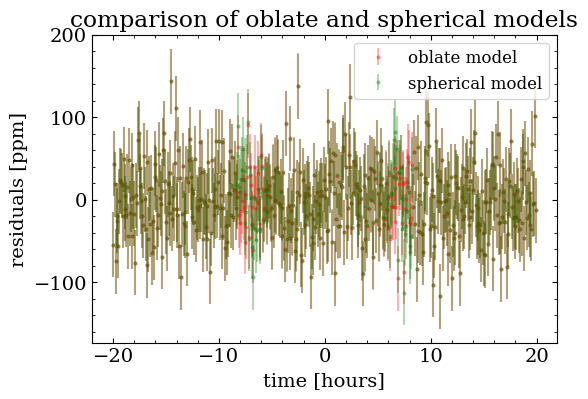

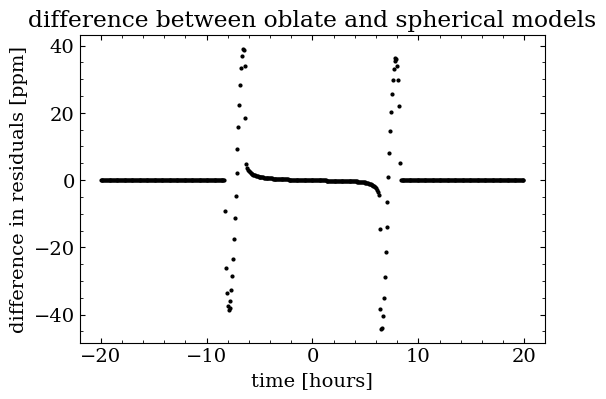

In [17]:
# plot the residual differences
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(
    times * u.day.to(u.hour),
    oblate_resids * 1e6,
    color="r",
    yerr=shot_noise_amplitude * 1e6,
    marker="o",
    markersize=2,
    ls="none",
    label="oblate model",
    alpha=0.3,
)
ax.errorbar(
    times * u.day.to(u.hour),
    sphere_resids * 1e6,
    color="g",
    yerr=shot_noise_amplitude * 1e6,
    marker="o",
    markersize=2,
    ls="none",
    label="spherical model",
    alpha=0.3,
)
ax.set(
    ylabel="residuals [ppm]",
    xlabel="time [hours]",
    title="comparison of oblate and spherical models",
)
ax.legend(prop={"size": 12});

# plot the model differences
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    times * u.day.to(u.hour),
    (oblate_resids - sphere_resids) * 1e6,
    color="k",
    marker="o",
    markersize=2,
    ls="none",
)
ax.set(
    ylabel="difference in residuals [ppm]",
    xlabel="time [hours]",
    title="difference between oblate and spherical models",
);


# do the model comparison:

# definitions:
# bic = -2 * log_likelihood + num_params * np.log(num_data_points)
# aic = -2 * log_likelihood + 2 * num_params

bic_oblate = -2 * (-res1.fun) + 8 * np.log(len(noised_data))
bic_sphere = -2 * (-res2.fun) + 6 * np.log(len(noised_data))

aic_oblate = -2 * (-res1.fun) + 16
aic_sphere = -2 * (-res2.fun) + 12

print(f"BIC oblate: {bic_oblate}")
print(f"BIC spherical: {bic_sphere}")
print(f"AIC oblate: {aic_oblate}")
print(f"AIC spherical: {aic_sphere}\n")

if bic_oblate < bic_sphere:
    print(
        f"The oblate model is preferred by BIC, delta BIC = {bic_sphere - bic_oblate}"
    )
else:
    print(
        f"The spherical model is preferred by BIC, delta BIC = {bic_oblate - bic_sphere}"
    )

if aic_oblate < aic_sphere:
    print(
        f"The oblate model is preferred by AIC, delta AIC = {aic_sphere - aic_oblate}"
    )
else:
    print(
        f"The spherical model is preferred by AIC, delta AIC = {aic_oblate - aic_sphere}"
    )

So, under these tests at least, it looks like the oblate model is preferred. In a real analysis situation we'd want to play with different limb darkening parameterizations and make sure that our recovery is robust, but hopefully this gives a starting point for how you might use `squishyplanet` to fit a model of an oblate planet.

### Nested Sampling

If we wanted to take another approach to model comparison and compute the Bayesian evidence for each fit, we'll have to run a nested sampling algorithm. To show how you might do that with `squishyplanet`, we'll use the [nautilus](https://nautilus-sampler.readthedocs.io/en/latest/index.html) library. ``nautilus``, which is described in full in [Lange 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.525.3181L/abstract), uses neural nets to help select new live points, which can dramatically speed up sampling. If we were doing a real analysis project, it'd be important to run convergence checks on the final results, but here we're just going to use conservative settings and hope for the best. Each of the following fits takes ~2 hours my laptop with no parallelization.

In [18]:
# construct the prior
np.random.seed(10)
prior = Prior()

# estimate uncertainty on mid-transit time: assume the uncertainties on the period and
# t_c are Gaussian and uncorrelated
tc_uncertainty = 0.00039  # u.day, from the 2010 Kepler epoch, Chachan+ 2020
period_uncertainty = 0.00059  # u.day, Chachan+ 2020
tc_draw = np.random.normal(loc=0, scale=tc_uncertainty, size=10_000)
period_deviation_draws = np.random.normal(loc=0, scale=period_uncertainty, size=10_000)
sims = period_deviation_draws * 5 + tc_uncertainty
t_peri_uncertainty = np.std(sims)
prior.add_parameter(
    "t_peri", dist=stats.norm(loc=-1071.23205 / 4, scale=t_peri_uncertainty)
)

a_uncertainty = ((0.027 * u.au) / (0.749 * u.R_sun)).to(u.dimensionless_unscaled).value
prior.add_parameter(
    "a",
    dist=stats.norm(
        loc=((1.883 * u.au) / (0.749 * u.R_sun)).to(u.dimensionless_unscaled),
        scale=a_uncertainty,
    ),
)

# straight from Chachan+ 2020
prior.add_parameter("b", dist=stats.norm(0.271, 0.073))

# using the Kipping 2013 uninformative quadratic limb darkening setup
prior.add_parameter("q1", dist=(0.0, 1.0))
prior.add_parameter("q2", dist=(0.0, 1.0))

# log-uniform prior on the jitter. between 0.1 and 100 ppm extra noise seems reasonable
prior.add_parameter("log_jitter", dist=(jnp.log(1e-7), jnp.log(1e-4)))

# to account for different bandpass, we'll scale the uncertainty by 3x
# (sort of accidentally simulated this by not adjusting the planet radius: the projected
# effective radius of the injected planet is smaller than the true radius, will be
# ~1sigma from this mean)
r_draws = (
    (
        np.random.normal(loc=10.16, scale=0.42, size=10_000)
        * u.R_earth
        / (0.749 * u.R_sun)
    )
    .to(u.dimensionless_unscaled)
    .value
)
r_mean = np.mean(r_draws)
r_std = np.std(r_draws) * 3
prior.add_parameter("projected_effective_r", dist=stats.norm(loc=r_mean, scale=r_std))

# large uniform prior on this
prior.add_parameter("projected_f", dist=(0.0, 0.15))

# completely unconstrained
prior.add_parameter("projected_theta", dist=(0.0, jnp.pi))

In [19]:
# since we're fitting for impact parameter b (not inclination i) and the limb darkening
# parameters q1 and q2 (not u1 and u2), we need to add a transformation before feeding
# the dictionary into the planet.loglike method
@jax.jit
def loglike(x):
    inc = jnp.arccos(x["b"] / x["a"])
    u1 = 2 * jnp.sqrt(x["q1"]) * x["q2"]
    u2 = jnp.sqrt(x["q1"]) * (1 - 2 * x["q2"])

    param_dict = {
        "t_peri": x["t_peri"],
        "a": x["a"],
        "i": inc,
        "ld_u_coeffs": jnp.array([u1, u2]),
        "projected_effective_r": x["projected_effective_r"],
        "projected_f": x["projected_f"],
        "projected_theta": x["projected_theta"],
        "log_jitter": x["log_jitter"],
    }
    return planet.loglike(param_dict)

# create the sampler
sampler1 = Sampler(
    prior,
    loglike,
    n_live=3000,
    seed=0,
    enlarge_per_dim=1.2, # larger than 1.1 default, but still manually set (i.e. no bootstrapping like UltraNest)
    filepath="nautilus_oblate_checkpoint.hdf5",
    resume=True,
)

# run it
sampler1.run(
    f_live=0.001, # default is 0.01, but we want to be more aggressive
    n_eff=50_000, # pretty large
    n_like_max=np.inf,
    discard_exploration=True, # see the nautlius paper, if False results will be faster but biased
    timeout=np.inf,
    verbose=True,
)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 55     | 2        | 4        | 275600   | N/A    | 50083 | +4142.34 


True

And now we can do the same for the spherical model:

In [20]:
# construct the prior
np.random.seed(10)
prior = Prior()

# estimate uncertainty on mid-transit time: assume the uncertainties on the period and
# t_c are Gaussian and uncorrelated
tc_uncertainty = 0.00039  # u.day, from the 2010 Kepler epoch, Chachan+ 2020
period_uncertainty = 0.00059  # u.day, Chachan+ 2020
tc_draw = np.random.normal(loc=0, scale=tc_uncertainty, size=10_000)
period_deviation_draws = np.random.normal(loc=0, scale=period_uncertainty, size=10_000)
sims = period_deviation_draws * 5 + tc_uncertainty
t_peri_uncertainty = np.std(sims)
prior.add_parameter(
    "t_peri", dist=stats.norm(loc=-1071.23205 / 4, scale=t_peri_uncertainty)
)

a_uncertainty = ((0.027 * u.au) / (0.749 * u.R_sun)).to(u.dimensionless_unscaled).value
prior.add_parameter(
    "a",
    dist=stats.norm(
        loc=((1.883 * u.au) / (0.749 * u.R_sun)).to(u.dimensionless_unscaled),
        scale=a_uncertainty,
    ),
)

# straight from Chachan+ 2020
prior.add_parameter("b", dist=stats.norm(0.271, 0.073))

# using the Kipping 2013 uninformative quadratic limb darkening setup
prior.add_parameter("q1", dist=(0.0, 1.0))
prior.add_parameter("q2", dist=(0.0, 1.0))

# log-uniform prior on the jitter. between 0.1 and 100 ppm extra noise seems reasonable
prior.add_parameter("log_jitter", dist=(jnp.log(1e-7), jnp.log(1e-4)))

# to account for different bandpass, we'll scale the uncertainty by 3x
# (sort of accidentally simulated this by not adjusting the planet radius: the projected
# effective radius of the injected planet is smaller than the true radius, will be
# ~1sigma from this mean)
r_draws = (
    (
        np.random.normal(loc=10.16, scale=0.42, size=10_000)
        * u.R_earth
        / (0.749 * u.R_sun)
    )
    .to(u.dimensionless_unscaled)
    .value
)
r_mean = np.mean(r_draws)
r_std = np.std(r_draws) * 3
prior.add_parameter("projected_effective_r", dist=stats.norm(loc=r_mean, scale=r_std))

# # large uniform prior on this
# prior.add_parameter("projected_f", dist=(0.0, 0.15))

# # completely unconstrained
# prior.add_parameter("projected_theta", dist=(0.0, jnp.pi))

In [21]:
# same as the oblate case
@jax.jit
def loglike(x):
    inc = jnp.arccos(x["b"] / x["a"])
    u1 = 2 * jnp.sqrt(x["q1"]) * x["q2"]
    u2 = jnp.sqrt(x["q1"]) * (1 - 2 * x["q2"])

    param_dict = {
        "t_peri": x["t_peri"],
        "a": x["a"],
        "i": inc,
        "ld_u_coeffs": jnp.array([u1, u2]),
        "projected_effective_r": x["projected_effective_r"],
        "projected_f": 0.0,
        "projected_theta": 0.0,
        "log_jitter": x["log_jitter"],
    }
    return planet.loglike(param_dict)


sampler2 = Sampler(
    prior,
    loglike,
    n_live=3000,
    seed=1,
    enlarge_per_dim=1.2,
    filepath="nautilus_sphere_checkpoint.hdf5",
    resume=True,
)
sampler2.run(
    f_live=0.001,
    n_eff=50_000,
    n_like_max=np.inf,
    discard_exploration=True,
    timeout=np.inf,
    verbose=True,
)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 53     | 1        | 4        | 235300   | N/A    | 50078 | +4132.57 


True

In [22]:
# the bayes factor is the ratio between the evidence of the two models:
print(
    f"the oblate model is preffered over the spherical model by a Bayes factor of: {jnp.exp(sampler1.log_z - sampler2.log_z)}"
)

the oblate model is preffered over the spherical model by a Bayes factor of: 17592.312534727695


So, with some caveats about this being conditional to the choice of prior and limb darkening parameterization, it looks like we successfully recovered an oblateness signal! Let's take a look at the posteriors:

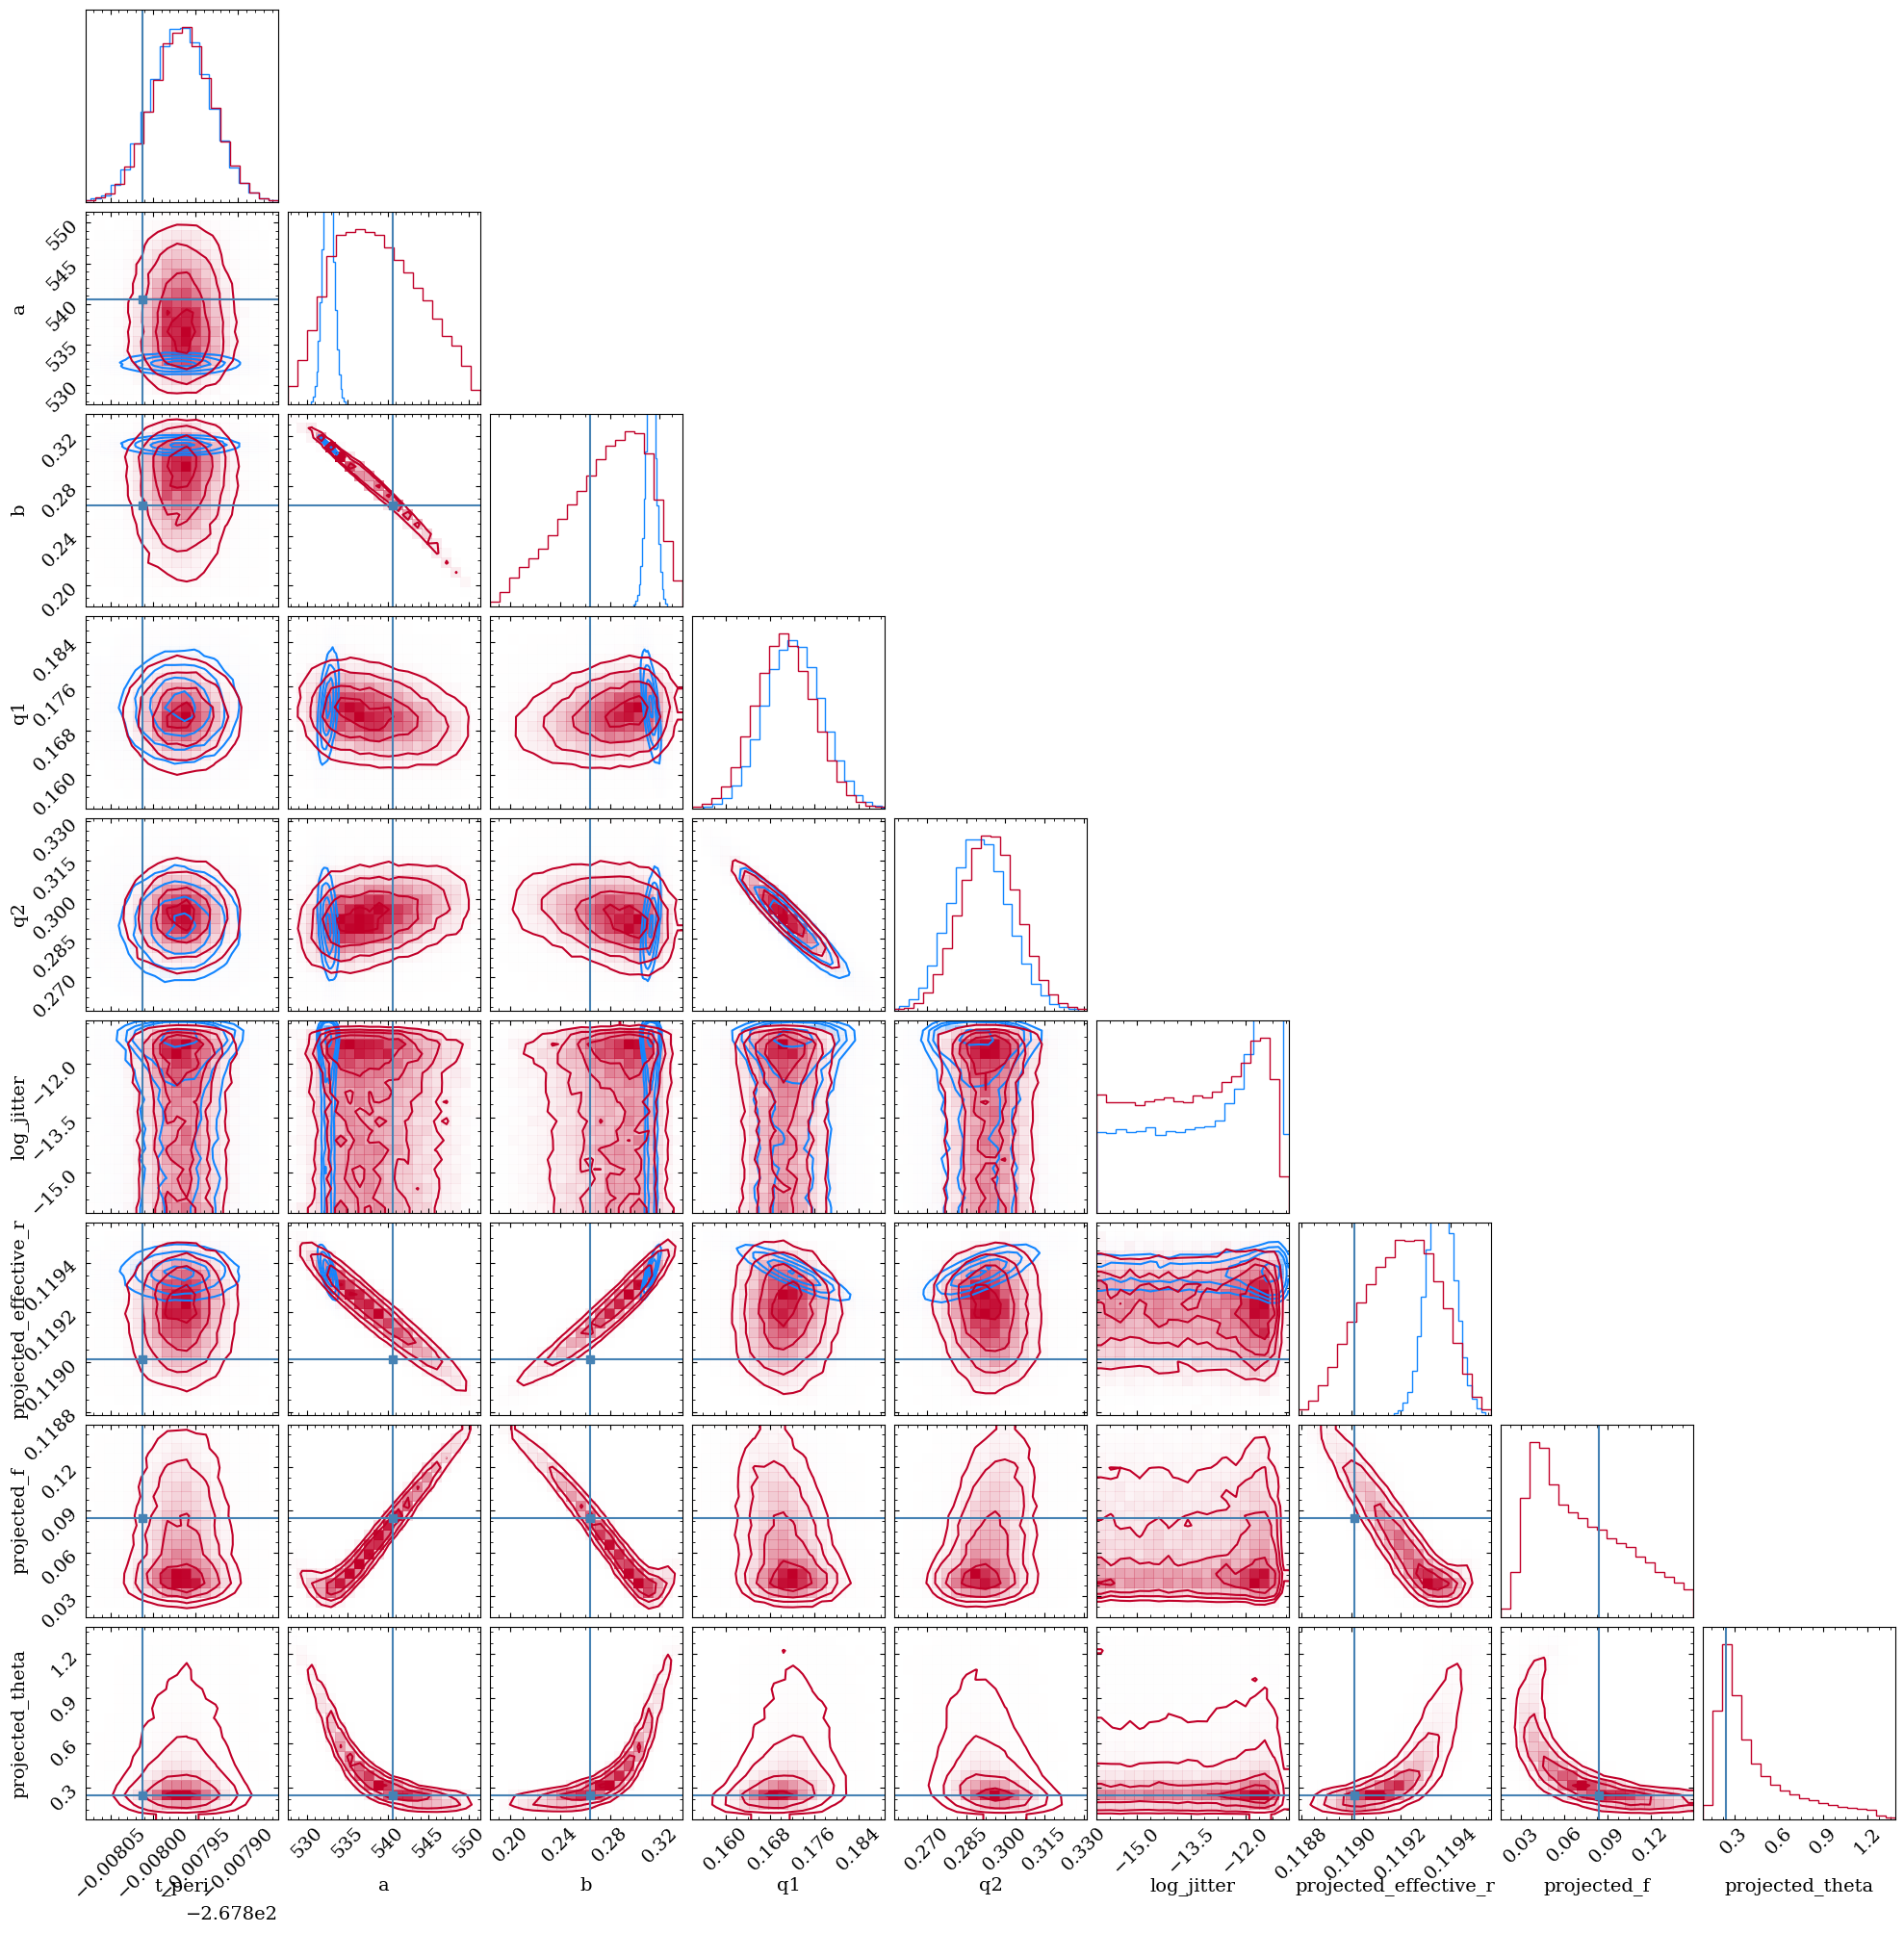

In [23]:
o_points, o_log_w, o_log_l = sampler1.posterior()
_s_points, _s_log_w, _s_log_l = sampler2.posterior()

s_points = np.zeros((len(_s_points), o_points.shape[1]))
s_points[:, :-2] = _s_points

truth = [
    injected_state["t_peri"],
    injected_state["a"].value,
    (injected_state["a"] * jnp.cos(injected_state["i"])).value,
    None,
    None,
    None,
    injected_planet.state["projected_effective_r"][0],
    injected_planet.state["projected_f"],
    injected_planet.state["projected_theta"][0],
]


warnings.filterwarnings("ignore")

f = corner.corner(
    s_points,
    weights=np.exp(_s_log_w),
    bins=20,
    labels=[
        "t_peri",
        "a",
        "b",
        "q1",
        "q2",
        "log_jitter",
        "projected_effective_r",
        "projected_f",
        "projected_theta",
    ],
    color="#1285ff",
    plot_datapoints=False,
    range=np.repeat(0.999, 9),
)


corner.corner(
    o_points,
    fig=f,
    weights=np.exp(o_log_w),
    bins=20,
    labels=[
        "t_peri",
        "a",
        "b",
        "q1",
        "q2",
        "log_jitter",
        "projected_effective_r",
        "projected_f",
        "projected_theta",
    ],
    color="#c10029",
    plot_datapoints=False,
    range=np.repeat(0.999, 9),
    truths=truth,
)

plt.savefig("corner_plot.png")

Above, the spherical model is in blue while the oblate is in red. Interestingly, the a and b posterior for the spherical model appear significantly biased aways from the injected values: to handle the slightly different ingress/egress times, the spherical model was forced to change the velocity of the planet and the length of its transit chord.

We can focus in on the marginalized posterior of the projected oblateness:

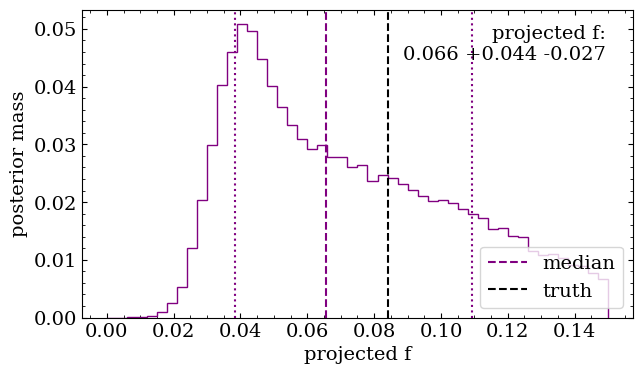

In [24]:
fig, ax = plt.subplots()
ax.hist(
    o_points[:, -2],
    bins=50,
    histtype="step",
    color="purple",
    weights=np.exp(o_log_w),
)
med = np.percentile(o_points[:, -2], 50)
low = np.percentile(o_points[:, -2], 16)
high = np.percentile(o_points[:, -2], 84)
ax.axvline(med, color="purple", ls="--", label="median")
ax.axvline(low, color="purple", ls=":")
ax.axvline(high, color="purple", ls=":")
ax.axvline(injected_planet.state["projected_f"], color="k", ls="--", label="truth")
ax.annotate(
    f"projected f:\n{med:.3f} +{high-med:.3f} -{med-low:.3f}",
    (0.95, 0.95),
    xycoords="axes fraction",
    ha="right",
    va="top",
)
ax.legend(loc="lower right")
ax.set(xlabel="projected f", ylabel="posterior mass");

We can see that the true value is nicely within the posterior, and that zero flattening is confidently ruled out.

Hopefully this gives a sense of how you might go about using `squishyplanet`. We used `nautlius` for our inference here, but we just as easily could have used other nested sampling frameworks like `dynesty` or `ultranest`, or even MCMC frameworks like `emcee`. We also could have used the `squishyplanet`-generated lightcurve as the mean for a more complicated systematics model, for example if we wanted to include a GP to model the stellar noise, or some kind of polynomial regression against engineering telemetry to model observatory systematics. `squishyplanet` is designed to leave the inference choices to the user, and just provides the tools to do the transit modeling and likelihood evaluation.